# 🧠 Autoencoders: A 3-Hour Lecture Outline

## ⏰ Total Duration: 3 Hours

---

## 🧭 0:00–0:15 — Introduction & Motivation

- What are autoencoders?
- Why use them? (Compression, denoising, manifold learning, etc.)
- Autoencoders vs PCA
- Real-world examples (image compression, anomaly detection)

---

## 🏗️ 0:15–0:45 — Vanilla Autoencoder Architecture

- Encoder-decoder structure
- Bottleneck representation (latent space)
- Activation functions (ReLU, sigmoid, tanh)
- Loss function: MSE
- Undercomplete vs overcomplete autoencoders

**🧪 Mini Demo**: Train an autoencoder on MNIST using PyTorch/Keras

---

## 📐 0:45–1:15 — Linear Autoencoders and PCA Connection

- No nonlinearity ⇒ linear AE ≈ PCA
- Derivation: Linear AE learns same subspace as PCA
- Why nonlinear AEs go beyond PCA
- Visualization of learned directions

**🧪 Mini Code**: Compare PCA and linear autoencoder on synthetic 2D data

---

## 🧹 1:15–1:30 — Denoising Autoencoders

- Intuition: robustness by reconstruction from corrupted input
- Injecting noise (Gaussian, masking)
- Regularization effect
- Applications in denoising and feature learning

**🧪 Mini Demo**: Denoising digits (MNIST with Gaussian noise)

---

## 🔒 1:30–1:50 — Sparse and Contractive Autoencoders

- Sparse AEs:
  - L1 regularization on latent activations
  - Biological motivation (sparse coding)
- Contractive AEs:
  - Penalty on Jacobian of encoder ⇒ local invariance
  - Connection to robustness

**🧠 Conceptual Visual**: Sparsity vs robustness in latent representations

---

## 🌐 1:50–2:20 — Variational Autoencoders (VAEs)

- Motivation: learn probabilistic latent representations
- Latent space as distribution (mean & variance)
- ELBO: Reconstruction + KL divergence
- Reparameterization trick
- Sampling from latent space

**🧪 Demo**: Generate digits using trained VAE

---

## 🎨 2:20–2:40 — Applications & Variants

- Applications:
  - Anomaly detection
  - Image generation
  - Clustering in latent space
- Variants:
  - Beta-VAE
  - Conditional AE/VAE
  - Vector quantized AEs (VQ-VAE)
  - Diffusion decoders

**🧠 Discussion**: When to use which variant?

---

## ❓ 2:40–3:00 — Open Problems + Q&A

- Disentanglement
- Representation interpretability
- Latent space metrics
- Current research directions

**🧠 Prompt**: Can AEs learn causally meaningful representations?

---

## 📎 Optional Materials

- Jupyter notebooks for each AE variant
- Suggested reading:
  - Bengio et al., "Representation Learning: A Review and New Perspectives" (2013)
  - Kingma & Welling, "Auto-Encoding Variational Bayes" (2014)
  - Higgins et al., "Beta-VAE" (2017)


https://arxiv.org/pdf/2201.03898

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt


In [57]:



# # Define transformations for the dataset
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
# ])

# # Download the MNIST dataset
# dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the dataset into train and test splits
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# # Create data loaders for train and test splits
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)



transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Optional: normalize to [-1, 1]
])
dataset = datasets.FakeData(size=1000, image_size=(1, 28, 28), num_classes=10, transform=transform)

# Split the dataset into train and test splits
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders for train and test splits
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


dataloaders = {'train': train_loader, 'val': test_loader}

print(f"Train dataset size: {len(train_loader)}")
print(f"Test dataset size: {len(test_loader)}")

dataset_sizes = {'train': len(train_loader.dataset), 'val': len(test_loader.dataset)}






Train dataset size: 50
Test dataset size: 13


In [58]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64),  # 28x28 = 784 for MNIST
            nn.ReLU(),
            nn.Linear(64, 2),  # 2D latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [59]:
model = Autoencoder()
# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.MSELoss()

# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam works better than SGD for autoencoders
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for x, _ in dataloaders['train']:
        x = x.to(device)
        x_flat = x.view(x.shape[0], -1)  # Flatten input
        
        # Forward pass
        x_hat = model(x_flat)
        loss = loss_fn(x_hat, x_flat)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
    
    epoch_loss = running_loss / dataset_sizes['train']
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')



Epoch 1/100, Loss: 0.5828
Epoch 2/100, Loss: 0.5687
Epoch 3/100, Loss: 0.5515
Epoch 4/100, Loss: 0.5284
Epoch 5/100, Loss: 0.4973
Epoch 6/100, Loss: 0.4605
Epoch 7/100, Loss: 0.4244
Epoch 8/100, Loss: 0.3954
Epoch 9/100, Loss: 0.3754
Epoch 10/100, Loss: 0.3626
Epoch 11/100, Loss: 0.3546
Epoch 12/100, Loss: 0.3496
Epoch 13/100, Loss: 0.3463
Epoch 14/100, Loss: 0.3441
Epoch 15/100, Loss: 0.3425
Epoch 16/100, Loss: 0.3415
Epoch 17/100, Loss: 0.3407
Epoch 18/100, Loss: 0.3401
Epoch 19/100, Loss: 0.3396
Epoch 20/100, Loss: 0.3393
Epoch 21/100, Loss: 0.3390
Epoch 22/100, Loss: 0.3388
Epoch 23/100, Loss: 0.3386
Epoch 24/100, Loss: 0.3384
Epoch 25/100, Loss: 0.3383
Epoch 26/100, Loss: 0.3382
Epoch 27/100, Loss: 0.3381
Epoch 28/100, Loss: 0.3380
Epoch 29/100, Loss: 0.3380
Epoch 30/100, Loss: 0.3379
Epoch 31/100, Loss: 0.3379
Epoch 32/100, Loss: 0.3378
Epoch 33/100, Loss: 0.3378
Epoch 34/100, Loss: 0.3377
Epoch 35/100, Loss: 0.3377
Epoch 36/100, Loss: 0.3377
Epoch 37/100, Loss: 0.3376
Epoch 38/1

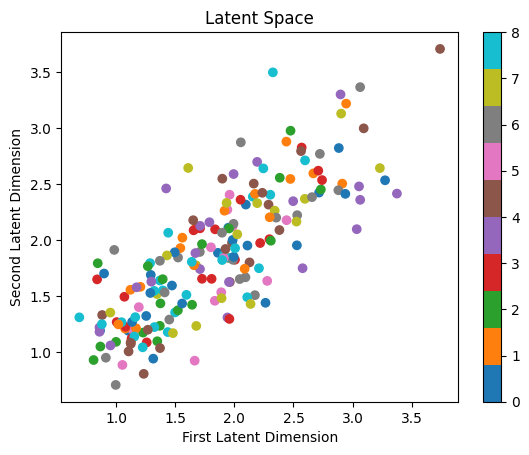

In [60]:
# Visualize the latent space
with torch.no_grad():
    for images, labels in dataloaders['val']:
        images = images.to(device)
        z = model.encoder(images)
        z = z.cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="tab10")
    plt.colorbar()
    plt.title('Latent Space')
    plt.xlabel('First Latent Dimension')
    plt.ylabel('Second Latent Dimension')
    plt.show()

In [ ]:


model = Autoencoder()
# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Combine MSE loss for reconstruction with cross-entropy loss for labels
reconstruction_loss = nn.MSELoss()
classification_loss = nn.CrossEntropyLoss()

def loss_fn(x_hat, x, true_labels, alpha=.8):
    recon_loss = reconstruction_loss(x_hat, x)
    # Calculate within-class and between-class variance
    z = model.encoder(x)  # Get latent representations
    
    # Calculate class means in latent space
    class_means = {}
    for label in torch.unique(true_labels):
        mask = (true_labels == label)
        class_means[label.item()] = z[mask].mean(dim=0)
    
    # Within-class variance: distance of points to their class mean
    within_var = 0
    for label in torch.unique(true_labels):
        mask = (true_labels == label)
        if mask.sum() > 0:  # Check if we have samples for this class
            diff = z[mask] - class_means[label.item()]
            within_var += torch.mean(torch.sum(diff**2, dim=1))
    
    # Between-class variance: distances between class means
    between_var = 0
    n_classes = len(class_means)
    if n_classes > 1:
        means = torch.stack([class_means[l.item()] for l in torch.unique(true_labels)])
        between_var = torch.mean(torch.pdist(means)**2)  # Negative because we want to maximize this
    class_loss = within_var/between_var  # Balance between the two terms
    return alpha * recon_loss + (1 - alpha) * class_loss

# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam works better than SGD for autoencoders
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for x, true_labels in dataloaders['train']:
        x = x.to(device)
        x_flat = x.view(x.shape[0], -1)  # Flatten input
        
        # Forward pass
        x_hat = model(x_flat)
        loss = loss_fn(x_hat, x_flat, true_labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
    
    epoch_loss = running_loss / dataset_sizes['train']
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')



Epoch 1/50, Loss: 1.0137
Epoch 2/50, Loss: 1.1694
Epoch 3/50, Loss: 1.0227
Epoch 4/50, Loss: 1.0002
Epoch 5/50, Loss: 1.0437
Epoch 6/50, Loss: 0.8891
Epoch 7/50, Loss: 0.9689
Epoch 8/50, Loss: 0.8463
Epoch 9/50, Loss: 0.9631
Epoch 10/50, Loss: 0.8157
Epoch 11/50, Loss: 0.9224
Epoch 12/50, Loss: 0.7656
Epoch 13/50, Loss: 0.8583
Epoch 14/50, Loss: 0.8389
Epoch 15/50, Loss: 0.7893
Epoch 16/50, Loss: 0.7407
Epoch 17/50, Loss: 0.7382
Epoch 18/50, Loss: 0.6867
Epoch 19/50, Loss: 0.7153
Epoch 20/50, Loss: 0.6606
Epoch 21/50, Loss: 0.6332
Epoch 22/50, Loss: 0.7112
Epoch 23/50, Loss: 0.6043
Epoch 24/50, Loss: 0.5842
Epoch 25/50, Loss: 0.5679
Epoch 26/50, Loss: 0.6059
Epoch 27/50, Loss: 0.5381
Epoch 28/50, Loss: 0.5580
Epoch 29/50, Loss: 0.4751
Epoch 30/50, Loss: 0.4964
Epoch 31/50, Loss: 0.5370
Epoch 32/50, Loss: 0.4723
Epoch 33/50, Loss: 0.4615
Epoch 34/50, Loss: 0.4455
Epoch 35/50, Loss: 0.4460
Epoch 36/50, Loss: 0.4224
Epoch 37/50, Loss: 0.4108
Epoch 38/50, Loss: 0.3945
Epoch 39/50, Loss: 0.

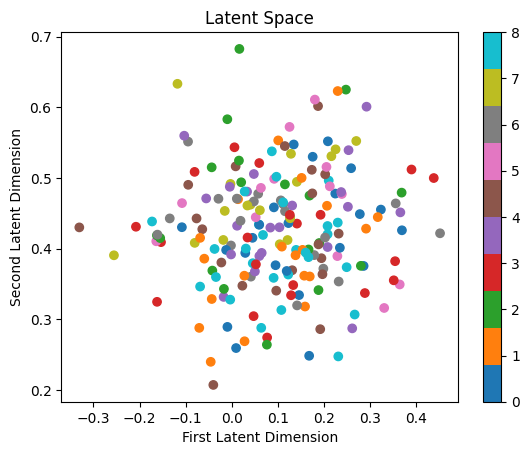

In [81]:
# Visualize the latent space
with torch.no_grad():
    for images, labels in dataloaders['val']:
        images = images.to(device)
        z = model.encoder(images)
        z = z.cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="tab10")
    plt.colorbar()
    plt.title('Latent Space')
    plt.xlabel('First Latent Dimension')
    plt.ylabel('Second Latent Dimension')
    plt.show()